# Реализовать синтезирование лиц из LFW с помощью DCGAN
 `Библиотеки: [Python, Tensorflow]`



## Переключение версии TensorFlow

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds


## Загрузка и подготовка датасета LFW

In [2]:
(train_x, test_x), ds_info = tfds.load('lfw', 
                               as_supervised=True,
                               with_info=True,
                               split=['train[:70%]', 'train[70%:]'],
                              )


In [3]:
train_x

<_OptionsDataset shapes: ((), (250, 250, 3)), types: (tf.string, tf.uint8)>

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    urls=['http://vis-www.cs.umass.edu/lfw'],
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

## Визуализация датасета LFW

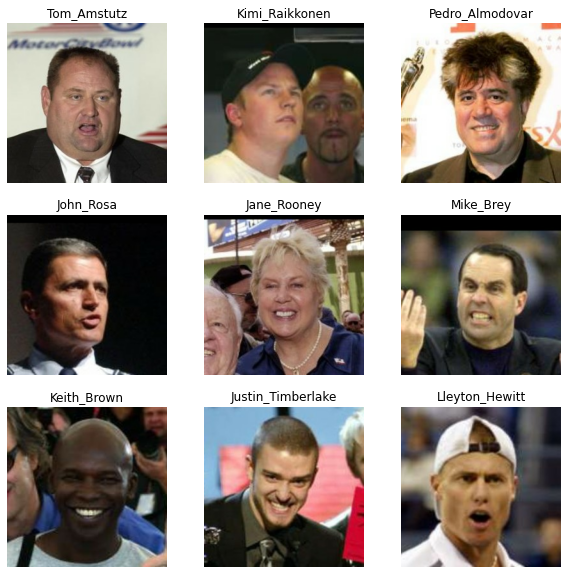

In [5]:
def plot_img(samples, flag_train=False):
    fig = plt.figure(figsize=(10, 10))
    for i, x in enumerate(samples):
        plt.subplot(3, 3, i+1)
        if not flag_train:
            plt.title(x[0].numpy().decode('utf-8'))
        plt.imshow(x[1])
        plt.axis('off')

        
plot_img(train_x.take(9))
 

## Создание Генератора и Дискриминатора

In [6]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(128*7*7, activation='relu'),
    tf.keras.layers.Reshape((7, 7, 128)),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),   
    
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(), 
    
    tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='tanh'),
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

## Подготовка пайплайна данных и оптимизатора

In [7]:
INPUT_DIM = 100
NUM_EPOCHS = 30
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.0002
IMG_SIZE = 56


In [8]:
def prepare_img(_, img):
    img = tf.cast(img, tf.float32) / 255
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img

In [9]:
train_ds = train_x.map(prepare_img)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

train_ds

<BatchDataset shapes: (16, 56, 56, 3), types: tf.float32>

In [10]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
def plot_img_train(samples):
    samples = samples / 2 + 0.5 
    fig = plt.figure(figsize=(16, 2))
    for i in range(samples.shape[0]):
        plt.subplot(1, 8, i+1)
        plt.imshow(samples[i])
        plt.axis('off')
    plt.show()
    
    
_noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
_syntetic_images = generator.predict(_noise)
_syntetic_images.shape


(16, 56, 56, 3)

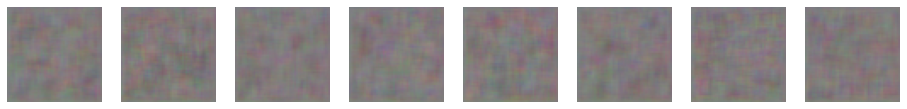

In [12]:
plot_img_train(_syntetic_images[:8, ...])

## Обучение GAN

[Step  0] D Loss: 1.2565; G Loss: 0.7080


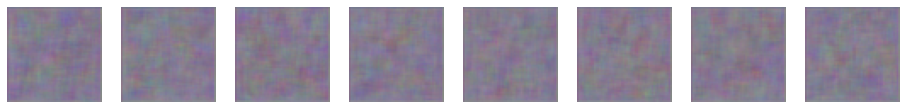

[Step 1000] D Loss: 0.4018; G Loss: 2.1397


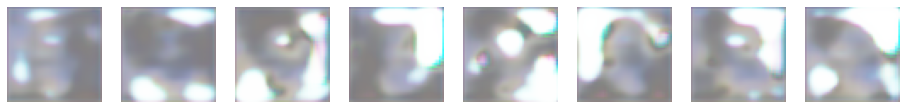

In [ ]:
%%time
discriminator_losses = []
generator_losses = []


for step, true_images in enumerate(train_ds):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    discriminator_losses.append(d_loss_value)
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    generator_losses.append(g_loss_value)
    
    # Check intermediate results
    
    if step % 1000 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_img_train(syntetic_images)


## Тестирование свёрточного генератора

In [ ]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_img_train(syntetic_images[:8])

## Интерполяция в латентном пространстве

In [ ]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_img_train(syntetic_images[:8])